In [1]:
from glob import glob
import pandas as pd
import networkx as nx
import pickle
import os
'''
Though not explicitly stated, I believe this "stopwords" package originates
from this pip package: https://pypi.org/project/stop-words/

It was the first result I found that shares the same name and get_stop_words
function call. 
'''
import stop_words
from dateutil import parser
from collections import defaultdict, Counter
import re
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from util.util import load, cache
from util.streamer import line_gen
from datetime import datetime
import numpy as np



# don't condense large numbers to scientific notation
pd.set_option('float_format', '{:f}'.format)

filenames = glob("data/BTC/json/*.jsonl")
stopwords = set(stop_words.get_stop_words('en'))
stopwords.update(['quote', 'pmquote', 'amquote', 'just', 'don', 'one', 'thing', 'even', 'way', 'maybe', 'also', 'please', 'well', 'actually', 'something',
                                         'going', 'anything', 'le', 'ever', 'say', 'see', 'likely', 'per', 'another', 'someone', 'let', 'anyone', 'doesn', 'include', 'doe', 'exactly',
                                         'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'like',
                                         'said', 'guy', 'will', 'can', 'able', 'people', 'become', 'tell', 'hey', 'much', 'many', 'lol', 'lot', 'want', 'still', 'really', 'think', 'didn',
                                         'isn', 'post', 'edited', 'share', 'facebookshare', 'twitter', 'monday', 'tuedsday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])
                                        # adding exclusions to 'bitcion' because presumably, the entire dataset contains
                                        # bitcoin-related tweets, which means mentions of bitcoin shouldn't add any value
lemmatizer = WordNetLemmatizer()


In [2]:
'''
Current preprocessing protocol

Remove:
Hyperlinks
Characters not in the English alphabetical character set a-z or A-Z
stopwords
words less than 3 characters
'bitcoins' and replace with 'bitcoin'

'''
def parse_string(input_string):
    input_string = input_string.lower()
    # remove links
    input_string = re.sub(r'http\S+', ' ', input_string)
    input_string = re.sub(r'\S+.(com|org)', '', input_string)
    # remove all non-English alphabet characters including numbers,
    # foreign and special characters
    input_string = re.sub( "[^a-zA-Z]", " ", input_string).split()

    # lemmatize word
    words = [lemmatizer.lemmatize(w) for w in input_string]
    # get rid of stopwords and words less than 3 characters
    words = [w for w in words if w not in stopwords and len(w) > 2]

    # fix common misspellings of bitcoin
    words = ["bitcoin" if w == "bitcoins" else w for w in words]
    words = ["bitcoin" if w == "itcoin" else w for w in words]

    return words


In [3]:
total_posts = 0
total_reple = 0
preprocessed_data = {}
preprocessed_data['user_network'] = nx.DiGraph()

# a dictionary of user's posts, their time, quantity
# accessed via preprocessed_data[field][user_name]
preprocessed_data['time_posts'] = defaultdict(list)
preprocessed_data['user_time_posts'] = defaultdict(dict)
preprocessed_data['user_posts'] = defaultdict(list)
preprocessed_data['user_posts_num'] = defaultdict(int)
preprocessed_data['get_comment_num'] = defaultdict(int)
preprocessed_data['write_comment_num'] = defaultdict(int)

# various Twitter metadata
preprocessed_data['verified'] = defaultdict(bool)
preprocessed_data['followers_count'] = defaultdict(int)

preprocessed_data['posts'] = []
voca = set()
word_freq = Counter()


In [4]:
fields = ['user_name', 'created_at', 'text', 'id', 'in_reply_to_screen_name']

# 400,000 tweets is the max my machine can load into RAM (total dataset is about 16 M)
# df = pd.concat([pd.read_json(filename, nrows=n_tweets/len(filenames), lines=True) for filename in filenames])
df = load('btc_data')

df = df.sort_values(by='in_reply_to_user_id')

# convert strings to datetime objects
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [5]:
print('posts: ', len(df[df['in_reply_to_user_id'].isna()]))
print('comments: ', len(df[df['in_reply_to_user_id'].notna()]))

posts:  100001
comments:  847744


{2019: 853377, 2015: 2113, 2018: 48449, 2017: 30052, 2011: 20, 2014: 7308, 2013: 2655, 2016: 3114, 2009: 1, 2012: 652, 2010: 4}


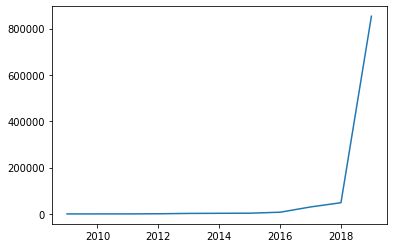

In [5]:
# date_counts = {}

# for row in df.itertuples():
#     if not row.created_at.year in date_counts:
#         date_counts[row.created_at.year] = 1
#     else:
#         date_counts[row.created_at.year] += 1

# print(date_counts)
# plt.plot(sorted(date_counts.keys()), sorted(date_counts.values()))

In [7]:
df.columns

Index(['created_at', 'in_reply_to_user_id', 'full_text', 'id', 'verified',
       'followers_count'],
      dtype='object')

In [8]:
# word_freq_file_name = 'pkl/word_freq_pkl' 

# # load cached result. Important: Make sure the number of tweets used is the same in the df!
# if os.path.exists(word_freq_file_name):
#     with open(word_freq_file_name, 'rb') as f:
#         word_freq = pickle.load(f)
# else:

#     with open(word_freq_file_name, 'wb') as f:
#         pickle.dump(word_freq, f)

# update word count
for i, text in enumerate(df["full_text"]):

    if i % 10000 == 0:
        print(f"\rposts: {i/len(df) * 100:.2f}% done", end='')
        
    text_body = parse_string(text)
    word_freq.update(text_body)

print(f"\rposts: {100:.2f}% done", end='')
print()
print("Number of unique words:", len(word_freq))

posts: 100.00% done
Number of unique words: 453807


In [9]:
user_processed_dict = {}

counter = 0

voca = set()

# only loop through posts. Comments will be counted if the user is found
# to be in the comments_user_dict 
for i, post in enumerate(df[df['in_reply_to_user_id'].isna()].itertuples()):

    post_user = post.id

    # add metadata
    preprocessed_data['verified'][post_user] = post.verified
    preprocessed_data['followers_count'][post_user] = post.followers_count

    if i % 5000 == 0:
        print(f"\r{i/len(df[df['in_reply_to_user_id'].isna()]) * 100:.2f}% done", end='')
        print(f"\r{preprocessed_data['user_network']}", end='')


    post_body = parse_string(post.full_text)
    post_body = [w for w in post_body if word_freq[w] >= 10]
    
    if len(post_body) < 5:
        continue

    voca.update(post_body)
    
    posted_time = post.created_at
    
    preprocessed_data['user_posts'][post_user].append(post_body)
    preprocessed_data['user_posts_num'][post_user] += 1
    preprocessed_data['time_posts'][posted_time].append(post_body)
    if posted_time in preprocessed_data['user_time_posts'][post_user]:
        preprocessed_data['user_time_posts'][post_user][posted_time].append(post_body)
    else:
        preprocessed_data['user_time_posts'][post_user][posted_time] = [post_body]
        
    preprocessed_data['posts'].append(post_body)

    if str(post_user) in user_processed_dict:
        continue

    post_comments = df[df['in_reply_to_user_id'] == post.id]
    
    for comment in post_comments.itertuples():

        user_processed_dict[str(post_user)] = True

        comment_body = parse_string(comment.full_text)

        comment_body = [w for w in comment_body if word_freq[w] >= 10]
        if len(comment_body) < 5:
            continue
        voca.update(comment_body)
        comment_user = comment.id
        comment_time = comment.created_at
            
        preprocessed_data['user_posts'][comment_user].append(comment_body)
        preprocessed_data['time_posts'][comment_time].append(comment_body)
        if posted_time in preprocessed_data['user_time_posts'][post_user]:
            preprocessed_data['user_time_posts'][post_user][posted_time].append(post_body)
        else:
            preprocessed_data['user_time_posts'][post_user][posted_time] = [post_body]
        
        preprocessed_data['posts'].append(comment_body)
        preprocessed_data['user_network'].add_edge(comment_user, post_user)
        preprocessed_data['get_comment_num'][post_user] += 1
        preprocessed_data['write_comment_num'][comment_user] += 1
        

print(f"\r{100:.2f}% done", end='')
print("\npickling...")

voca = list(voca)
preprocessed_data['voca'] = voca
preprocessed_data['word_freq'] = word_freq
with open("pkl/preprocessed_bitcoin.pkl", 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Number of unique vocabulary words", len(voca))
print()
print("finished")



100.00% done
pickling...
Number of unique vocabulary words 36923

finished


In [10]:
print(preprocessed_data['user_network'])

DiGraph with 61442 nodes and 180474 edges


In [11]:
# nx.draw_shell(preprocessed_data["user_network"], with_labels=True)


In [12]:
b = [len(a) for a in list(preprocessed_data['user_network'].adj.values())]
print(max(b))


90
